# Equivariance check | Generalized Lipschitz Group Equivariant Neural Networks (GLGENN)

## Imports and installs

In [48]:
import os
import torch
torch.set_default_dtype(torch.float64)
import json
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt

In [49]:
os.chdir('/')
if not os.path.exists("/glgenn"):
    !git clone https://github.com/katyafilimoshina/glgenn
else:
    os.chdir("/glgenn")
    !git pull origin main

# os.chdir("/glgenn")

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 3), reused 7 (delta 2), pack-reused 0
Unpacking objects: 100% (8/8), 19.77 KiB | 289.00 KiB/s, done.
From https://github.com/katyafilimoshina/glgenn
 * branch            main       -> FETCH_HEAD
   09d85fe..f2fafe9  main       -> origin/main
Updating 09d85fe..f2fafe9
Fast-forward
 experiments/GLGENN_Equivariance_Check.ipynb | 438 ++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 438 insertions(+)
 create mode 100644 experiments/GLGENN_Equivariance_Check.ipynb


In [50]:
from glgenn.layers.qtlinear import QTLinear
from glgenn.layers.qtgp import QTGeometricProduct
from glgenn.layers.qtnorm import QTNormalization
from glgenn.algebra.cliffordalgebraex import CliffordAlgebraQT

## Data generation

In [61]:
h = torch.randn(1, 8, 1) # 8 scalars, batch_size=1
x = torch.randn(1, 8, 3) # 8 vectors with 3 coordinates, batch_size=1

In [62]:
algebra = CliffordAlgebraQT((1.,) * 3)

In [63]:
h_cl = algebra.embed_grade(h, 0)
x_cl = algebra.embed_grade(x, 1)

input = torch.cat([h_cl, x_cl], dim=1)

## Define orthogonal transformations

In [64]:
# Reflector
v = algebra.versor(1)

# Rotor
R = algebra.versor(2)

In [65]:
input_v = algebra.rho(v, input.clone()) # reflected data
input_R = algebra.rho(R, input.clone()) # rotated data

In [66]:
# check that transformations are orthogonal

assert torch.allclose(algebra.norm(input_v), algebra.norm(input))
assert torch.allclose(algebra.norm(input_R), algebra.norm(input))

## Define GLGENN layers

In [67]:
qt_gp = QTGeometricProduct(algebra, 16)
qt_linear = QTLinear(algebra, 16, 16)
qt_norm = QTNormalization(algebra, 16)

## Equivariance check

Check equivariance of `QTGeometricProduct` layer:

In [68]:
output = qt_gp(input)
output_v = qt_gp(input_v)
output_R = qt_gp(input_R)

assert torch.allclose(algebra.rho(v, output), output_v)
assert torch.allclose(algebra.rho(R, output), output_R)

In [69]:
algebra.rho(v, output), output_v

(tensor([[[-9.9657e-02,  8.8615e-02,  4.2689e-02,  6.4706e-02, -6.9389e-18,
            0.0000e+00, -3.4694e-18,  0.0000e+00],
          [ 9.4359e-02, -3.8074e-02,  5.5783e-02, -5.5045e-02,  0.0000e+00,
            1.7347e-18,  0.0000e+00,  0.0000e+00],
          [-3.0863e-01, -1.2045e-01,  1.0775e-01,  2.2763e-01,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  1.3878e-17],
          [-1.0193e-01,  3.4161e-01, -1.7653e-02,  9.6752e-01,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 3.1633e-01, -8.6709e-02, -7.9784e-03,  3.7707e-02, -1.3878e-17,
            0.0000e+00,  0.0000e+00, -1.0842e-18],
          [ 1.8632e-03,  7.3516e-02,  1.5043e-01, -5.7786e-01,  0.0000e+00,
            2.7105e-20,  5.4210e-20,  0.0000e+00],
          [ 1.1876e+00,  8.5845e-03, -1.3210e-01, -5.9127e-02,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  3.4694e-18],
          [-1.8567e+00, -3.8080e-01,  6.0721e-02, -2.6701e-01,  0.0000e+00,
            0.0000e+00,  0.0000e+00

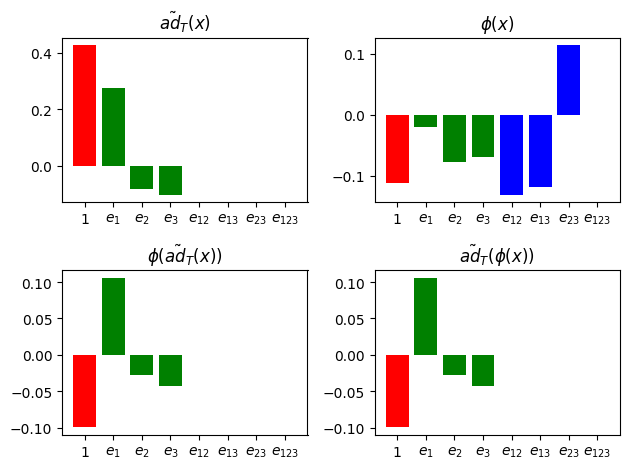

In [70]:
# Labels
x = ['$1$', '$e_1$', '$e_2$', '$e_3$', '$e_{12}$', '$e_{13}$', '$e_{23}$', '$e_{123}$']
fig, axes = plt.subplots(nrows=2, ncols=2)

# First bar chart (top left)
axes[0, 0].bar(x, input_R[0, :].mean(0).detach(), color=['red', 'green', 'green', 'green', 'blue' , 'blue', 'blue', 'yellow'])
axes[0, 0].set_title(r"$\tilde{ad}_T(x)$")

# Second bar chart (top right)
axes[0, 1].bar(x, qt_gp(input)[0].mean(0).detach(), color=['red', 'green', 'green', 'green', 'blue' , 'blue', 'blue', 'yellow'])
axes[0, 1].set_title(r"$\phi(x)$")

# Third bar chart (bottom left)
axes[1, 0].bar(x, algebra.rho(R, output).detach()[0, 0], color=['red', 'green', 'green', 'green', 'blue' , 'blue', 'blue', 'yellow'])
axes[1, 0].set_title(r"$\phi(\tilde{ad}_T(x))$")

# Fourth bar chart (bottom right)
axes[1, 1].bar(x, output_R.detach()[0, 0], color=['red', 'green', 'green', 'green', 'blue' , 'blue', 'blue', 'yellow'])
axes[1, 1].set_title(r"$\tilde{ad}_T(\phi(x))$")

plt.tight_layout()
plt.show()

Check equivariance of `QTLinear` layer:

In [71]:
output = qt_linear(input)
output_v = qt_linear(input_v)
output_R = qt_linear(input_R)

assert torch.allclose(algebra.rho(v, output), output_v)
assert torch.allclose(algebra.rho(R, output), output_R)

Check equivariance of `QTNormalization` layer:

In [72]:
output = qt_norm(input)
output_v = qt_norm(input_v)
output_R = qt_norm(input_R)

assert torch.allclose(algebra.rho(v, output), output_v)
assert torch.allclose(algebra.rho(R, output), output_R)